<a href="https://colab.research.google.com/github/nlpvoteproject1/SAbert/blob/main/Section_4_BERT_Current_labelled.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Table of contents

- [Setup](#s1)
  - [Importing and Exploring Data](#s1.1)
- [Pre-processing](#s2)
  - [Setup model](#s2.1)
  - [Tokenize data](#s2.2)
  - [Training/Validation split](#s2.3)
- [Training the model](#s3)
  - [Optimizer and Learning Rate Scheduler](#s3.1)
  - [Training Loop](#s3.2)
    - [Training](#s3.2.1)
    - [Evaluation](#s3.2.2)
- [Testing the model](#s4)
  - [Data preparation](#s4.1)
  - [Evaluation](#s4.2)
    - [Matthews correlation coefficient](#s4.2.1)
    - [Classification report](#s4.2.2)
  - [Saving fine-tuned model](#s4.3)
  - [Loading model](#s4.4)

### Based on code from:

- https://curiousily.com/posts/sentiment-analysis-with-bert-and-hugging-face-using-pytorch-and-python/
- https://github.com/google-research/bert/blob/master/predicting_movie_reviews_with_bert_on_tf_hub.ipynb
- https://github.com/ronva-h/Sentiment-Analysis-with-Deep-Learning-using-BERT/blob/master/Project.ipynb
- https://www.coursera.org/projects/sentiment-analysis-bert
- https://mccormickml.com/2019/07/22/BERT-fine-tuning/#31-bert-tokenizer
- https://towardsdatascience.com/multi-class-text-classification-with-deep-learning-using-bert-b59ca2f5c613
- https://colab.research.google.com/drive/1pTuQhug6Dhl9XalKB0zUGf4FIdYFlpcX#scrollTo=gFsCTp_mporB

<a id='s1'></a>
## Setup

In [ ]:
#Pip installs

import sys

#Install pytorch with CUDA
!{sys.executable} -m pip install torch==1.8.1+cu111 torchvision==0.9.1+cu111 torchaudio===0.8.1 -f https://download.pytorch.org/whl/torch_stable.html

#Install tensorflow
!{sys.executable} -m pip install tensorflow

#Install hugging face
!{sys.executable} -m pip install transformers

#Texblob
!{sys.executable} -m pip install textblob

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |█████████████▌                  | 834.1 MB 1.6 MB/s eta 0:11:45tcmalloc: large alloc 1147494400 bytes == 0x56038638e000 @  0x7f606aa66615 0x560383ce54cc 0x560383dc547a 0x560383ce82ed 0x560383dd9e1d 0x560383d5be99 0x560383d569ee 0x560383ce9bda 0x560383d5bd00 0x560383d569ee 0x560383ce9bda 0x560383d58737 0x560383ddac66 0x560383d57daf 0x560383ddac66 0x560383d57daf 0x560383ddac66 0x560383d57daf 0x560383cea039 0x560383d2d409 0x560383ce8c52 0x560383d5bc25 0x560383d569ee 0x560383ce9bda 0x560383d58737 0x560383d569ee 0x560383ce9bda 0x560383d57915 0x560383ce9afa 0x560383d57c0d 0x560383d569ee
     |█████████████████               | 1055.7 MB 1.5 MB/s eta 0:10:28tcmalloc: large alloc 1434370048 bytes == 0x5603ca9e4000 @  0x7f606aa66615 0x560383ce54cc 0x560383dc547a 0x560383ce82ed 0x560383dd9e1d 0x560383d5be99 0x560383d569ee 0x560383ce9bda 0x560383d5bd00 0x560383d569ee 0x560383ce9bda 0x560383d58737 0x560383ddac66 0x560383d57d

In [ ]:
#Imports

#Import Pandas and numpy
import pandas as pd
import numpy as np

#Sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

#Hugging Face library
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
from transformers import TFBertForSequenceClassification, BertForSequenceClassification
from transformers import InputExample, InputFeatures

#Tensorflow
import tensorflow as tf

#pytorch
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import TensorDataset, random_split

#Visualisation tools
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc

#General use
from collections import Counter
import time
import datetime
import random
import os

#Setting display options 

pd.set_option('display.max_columns', None)
%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8

#Setting seed

r_seed = 13
np.random.seed(r_seed)
torch.manual_seed(r_seed)


In [ ]:
# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


In [ ]:
# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla K80


<a id='s1.1'></a>
### Importing and Exploring Data

In [ ]:
#Importing the dataset
#username;date;retweets;favorites;text;geo;mentions;hashtags;id;permalink

df = pd.read_csv('labelled_tweets_sub_c.csv')

In [ ]:
df.shape

(128954, 3)

In [ ]:
#df["sentiment"]=df["sentiment"].astype('int64')

In [ ]:
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128954 entries, 0 to 128953
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   created_at  128954 non-null  object 
 1   text        128954 non-null  object 
 2   sentiment   128954 non-null  float64
dtypes: float64(1), object(2)
memory usage: 3.0+ MB


,created_at,text,sentiment
0,25/05/2018 05:32,"As a man, adopted in Ireland 30 years ago wher...",3.0
1,24/05/2018 07:11,In about 24 hours our brilliant daughter gets ...,3.0
2,23/05/2018 20:11,"Just in case anyone was unsure of my stance, t...",3.0
3,22/05/2018 13:15,#repeal8th #repeal8thamendment \n#vote #may25t...,3.0
4,24/05/2018 08:58,In the 90s we hosted Irish women coming to Liv...,3.0


In [ ]:
class_names = ['v negative','negative', 'neutral', 'positive','v positive']

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


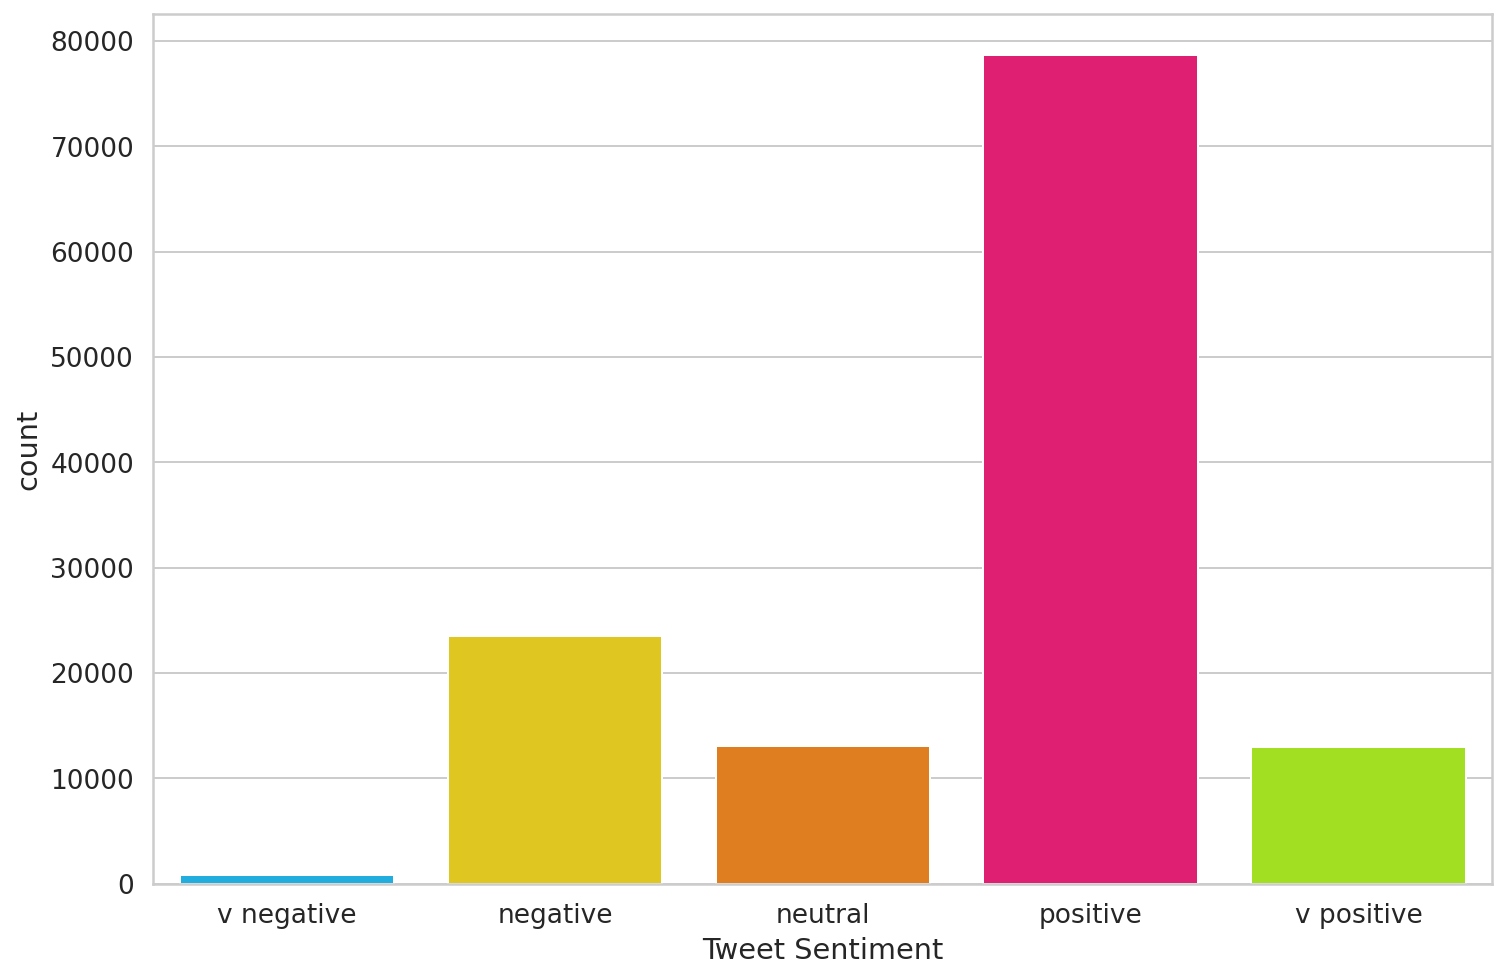

In [ ]:
#Plot class distributions

ax = sns.countplot(df.sentiment)
plt.xlabel('Tweet Sentiment')
ax.set_xticklabels(class_names);

In [ ]:
#Splitting the data into a train and test set
df_train, df_test = train_test_split(df, test_size=0.1, random_state=r_seed, stratify=df.sentiment)

df_train.shape, df_test.shape

((116058, 3), (12896, 3))

In [ ]:
#Set df to df_train for the setup and training of the model
df = df_train

<a id='s2'></a>
## Pre-processing

<a id='s2.1'></a>
### Setup model

In [ ]:
# Use the 12-layer BERT model, with a cased vocab
pt_model_name = 'bert-base-cased'

# Use the 24-layer BERT model, with a cased vocab
#pt_model_name = 'bert-large-cased'

In [ ]:
# The number of output labels
num_classes=len(df.sentiment.unique())

In [ ]:
num_classes

5

In [ ]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [ ]:
# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model = BertForSequenceClassification.from_pretrained(
    pt_model_name, 
    num_labels = num_classes,  
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/416M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

In [ ]:
# Tell pytorch to run this model on the GPU.
model.cuda()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [ ]:
#Set the tokenizer
tokenizer = BertTokenizer.from_pretrained(pt_model_name)

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/426k [00:00<?, ?B/s]

In [ ]:
#model.summary()

<a id='s2.2'></a>
### Tokenize Data

In [ ]:
#Find the length of all token sequences
token_lens = []
for txt in df.text:
  tokens = tokenizer.encode(txt, max_length=512, truncation=True)
  token_lens.append(len(tokens))

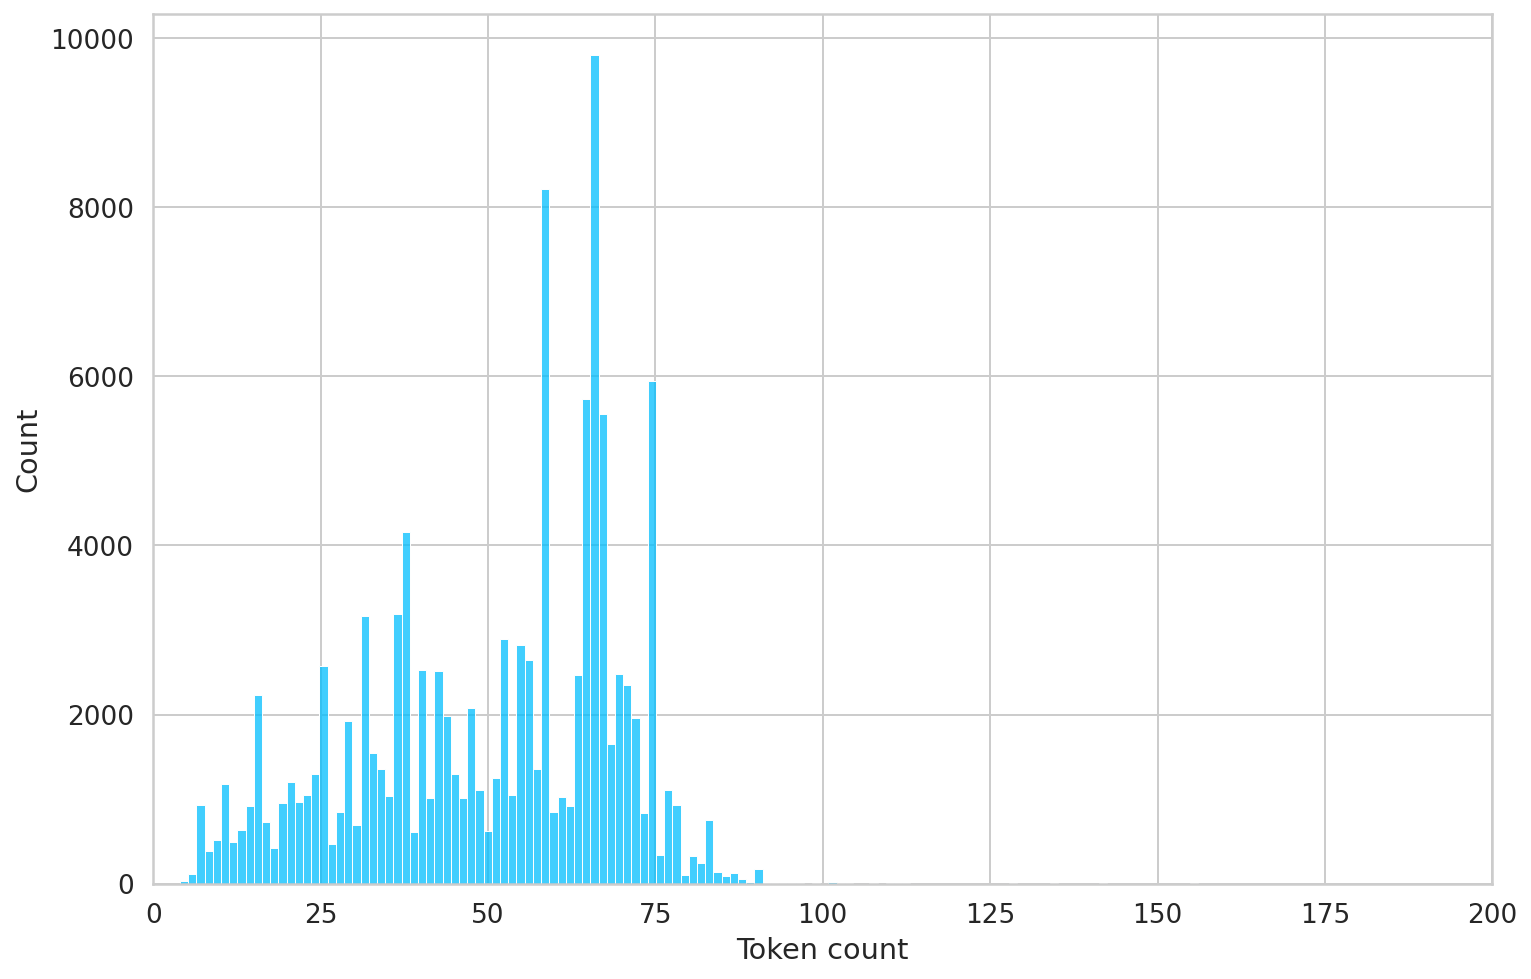

In [ ]:
#Plot token lengths
sns.histplot(token_lens)
plt.xlim([0, 200]);
plt.xlabel('Token count');

In [ ]:
#Print out the token counts

Counter(token_lens).most_common

<bound method Counter.most_common of Counter({66: 9799, 59: 6891, 65: 5735, 67: 5553, 74: 4754, 38: 4154, 55: 2828, 56: 2643, 40: 2530, 36: 2509, 71: 2346, 16: 2233, 53: 2181, 32: 2070, 44: 1986, 72: 1963, 29: 1920, 70: 1748, 68: 1646, 33: 1549, 26: 1522, 34: 1356, 57: 1354, 42: 1338, 58: 1330, 64: 1323, 45: 1300, 24: 1298, 47: 1271, 51: 1249, 75: 1187, 43: 1179, 11: 1173, 63: 1142, 49: 1107, 77: 1105, 31: 1098, 25: 1058, 23: 1045, 54: 1043, 35: 1039, 61: 1021, 46: 1014, 41: 1011, 22: 971, 19: 957, 7: 933, 78: 926, 62: 918, 60: 850, 28: 850, 73: 840, 48: 807, 83: 754, 69: 734, 17: 727, 52: 708, 30: 695, 37: 677, 13: 629, 50: 619, 39: 614, 20: 608, 21: 592, 12: 488, 27: 471, 14: 460, 15: 455, 18: 416, 8: 388, 76: 334, 9: 275, 82: 248, 10: 244, 80: 196, 84: 137, 81: 136, 87: 124, 6: 108, 79: 107, 91: 103, 85: 74, 90: 64, 88: 52, 89: 23, 5: 20, 86: 20, 102: 19, 4: 14, 97: 11, 103: 7, 92: 7, 94: 7, 134: 5, 93: 5, 128: 4, 95: 3, 99: 3, 111: 2, 142: 2, 113: 2, 104: 2, 110: 2, 107: 2, 156: 2,

In [ ]:
#Set max sequence length
max_len=100

In [ ]:
# Get the lists of sentences and their labels.
sentences = df.text.values
labels = df.sentiment.values

In [ ]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for sent in sentences:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = max_len,           # Pad & truncate all sentences.
                        padding = 'max_length',
                        truncation = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Print sentence 0, now as a list of IDs.
print('Original: ', sentences[0])
print('Token IDs:', input_ids[0])

Original:  Does anyone else get a nice sense of comradery when passing out someone whos also wearing a  or a  jumper? I know I do, every time  we are #Together4Yes
Token IDs: tensor([  101,  7187,  2256,  1950,  1243,   170,  3505,  2305,  1104,  3254,
        12673,  1616,  1165,  3744,  1149,  1800,  1150,  1116,  1145,  3351,
          170,  1137,   170, 25563,   136,   146,  1221,   146,  1202,   117,
         1451,  1159,  1195,  1132,   108,  6333,  1527,  3663,  1279,   102,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0])


<a id='s2.3'></a>
### Training/Validation split

In [ ]:
from torch.utils.data import TensorDataset, random_split

# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(input_ids, attention_masks, labels)

# Create a 90-10 train-validation split.

# Calculate the number of samples to include in each set.
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

104,452 training samples
11,606 validation samples


In [ ]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it 
# here. For fine-tuning BERT on a specific task, the authors recommend a batch 
# size of 16 or 32.
batch_size = 16

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

<a id='s3'></a>
## Training the model

<a id='s3.1'></a>
### Optimizer and Learning Rate Scheduler

In [ ]:
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

In [ ]:
# Number of training epochs. The BERT authors recommend between 2 and 4. 
epochs = 2

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

<a id='s3.2'></a>
### Training Loop

In [ ]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))


<a id='s3.2.1'></a>
#### Training

In [ ]:
# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# Set the seed value all over the place to make this reproducible.
seed_val = r_seed

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 200 batches.
        if step % 200 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # In PyTorch, calling `model` will in turn call the model's `forward` 
        # function and pass down the arguments. The `forward` function is 
        # documented here: 
        # https://huggingface.co/transformers/model_doc/bert.html#bertforsequenceclassification
        # The results are returned in a results object, documented here:
        # https://huggingface.co/transformers/main_classes/output.html#transformers.modeling_outputs.SequenceClassifierOutput
        # Specifically, we'll get the loss (because we provided labels) and the
        # "logits"--the model outputs prior to activation.
        
        result = model(b_input_ids, 
                       token_type_ids=None, 
                       attention_mask=b_input_mask, 
                       labels=b_labels,
                       return_dict=True)
                
        print(f"{b_labels}\n,{b_input_mask}\n,{b_input_mask}\n")
        loss = result.loss
        logits = result.logits

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using 
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            result = model(b_input_ids, 
                           token_type_ids=None, 
                           attention_mask=b_input_mask,
                           labels=b_labels,
                           return_dict=True)

        # Get the loss and "logits" output by the model. The "logits" are the 
        # output values prior to applying an activation function like the 
        # softmax.
        loss = result.loss
        logits = result.logits
            
        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 2 ========
Training...


ValueError: ignored

<a id='s3.2.2'></a>
#### Evaluation

In [ ]:
import pandas as pd

# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.13,0.09,0.98,4:36:23,0:09:21
2,0.04,0.05,0.99,4:35:50,0:09:21


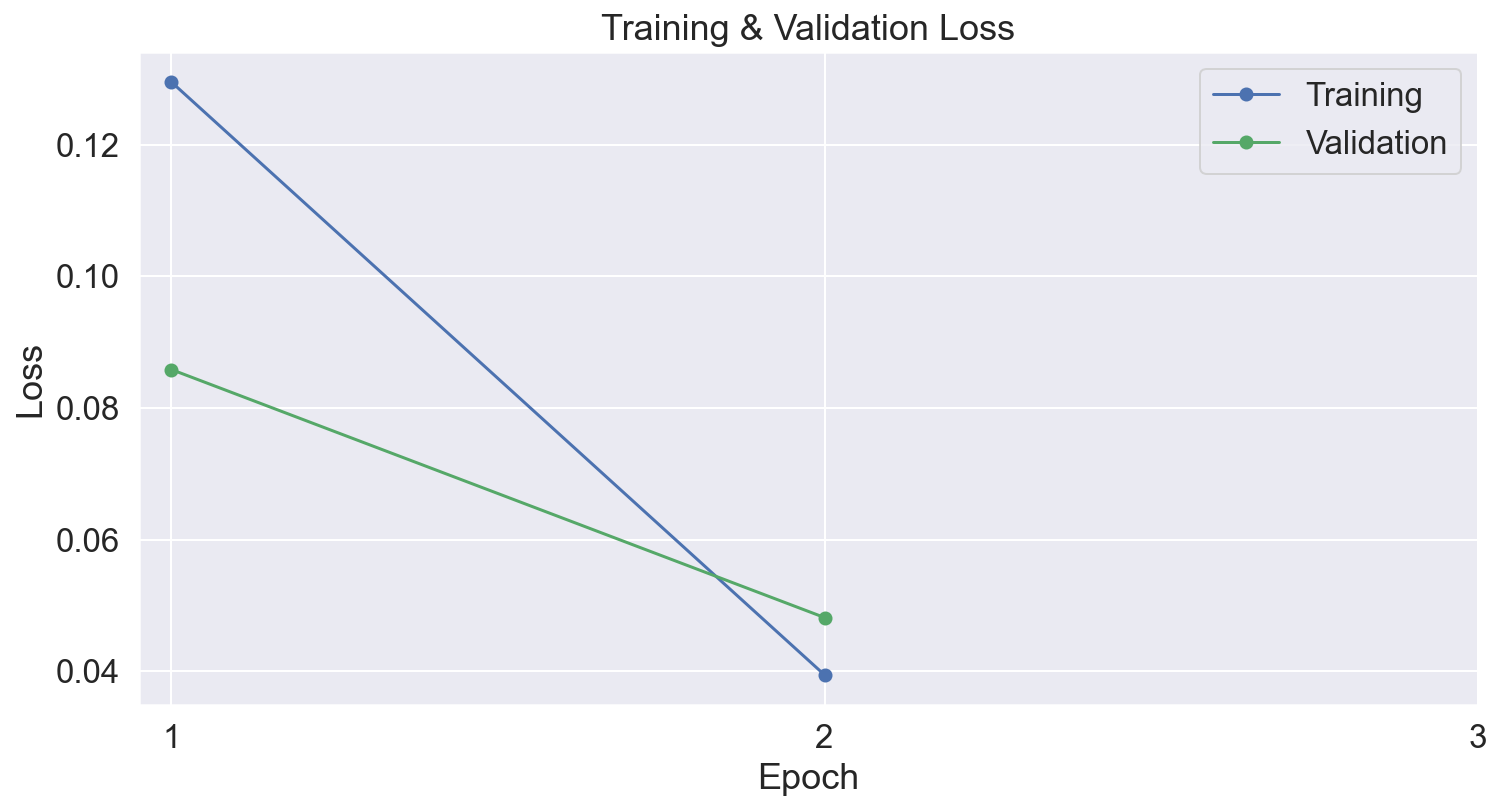

In [ ]:
import matplotlib.pyplot as plt
#% matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3])

plt.show()

<a id='s4'></a>
## Testing the model

<a id='s4.1'></a>
### Data Preparation

In [ ]:
#Set the dataset to the reserved training set from above
df = df_test

print(df.shape)

(219521, 3)


In [ ]:
df.reset_index(drop=True, inplace=True)

In [ ]:
# Create sentence and label lists
sentences = df.text.values
labels = df.sentiment.values

In [ ]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

In [ ]:
#Tokenize sentences
for sent in sentences:

    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = max_len,           # Pad & truncate all sentences.
                        padding = 'max_length',
                        truncation = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
        
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

In [ ]:
# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

In [ ]:
# Set the batch size.  
batch_size = 16  

In [ ]:
# Create the DataLoader.
prediction_data = TensorDataset(input_ids, attention_masks, labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

<a id='s4.2'></a>
### Evaluation

In [ ]:
# Prediction on test set

print('Predicting labels for {:,} test tweets...'.format(len(input_ids)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

t0 = time.time()

# Predict 
for batch in prediction_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)

    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch

    # Progress update every 200 batches.
    if step % 200 == 0 and not step == 0:
        # Calculate elapsed time in minutes.
        elapsed = format_time(time.time() - t0)

        # Report progress.
        print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

    # Telling the model not to compute or store gradients, saving memory and 
    # speeding up prediction
    with torch.no_grad():
        # Forward pass, calculate logit predictions.
        result = model(b_input_ids, 
                       token_type_ids=None, 
                       attention_mask=b_input_mask,
                       return_dict=True)
    logits = result.logits

    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    # Store predictions and true labels
    predictions.append(logits)
    true_labels.append(label_ids)

print('    DONE.')

Predicting labels for 219,521 test tweets...
    DONE.


<a id='s4.2.2'></a>
#### Classification Report

In [ ]:
cnt=0
bpred= []
j=len(predictions)

#Create a list of BERT's predicted values for each tweet

#Loop through every batch of predictions
for i in range(j):
    
    #Calculate the prediction for the batch
    pred_labels_i = np.argmax(predictions[i], axis=1).flatten()
    
    #Go through each entry in the batch and add it to the list
    for k in range(len(pred_labels_i)):
        #text=df['text'][cnt]
        #sent=df['sentiment'][cnt]
        #print(f"i:{i}\tk:{cnt}\nText: {text}\nSentiment:{sent}\tPred:{pred_labels_i[k]}")
        bpred.append(pred_labels_i[k])
        cnt += 1
    

#Create a new column with the predicted values for each tweet    
df["b_pred"]=bpred    

In [ ]:
y_true=df.sentiment
y_pred=df.b_pred
target_names= ['v neg', 'neg', 'neu','pos','v pos']

In [ ]:
print(classification_report(y_true, y_pred, target_names=target_names))

              precision    recall  f1-score   support

       v neg       0.96      0.98      0.97      3614
         neg       0.99      0.99      0.99     54106
         neu       0.99      0.98      0.99     41525
         pos       0.99      0.99      0.99    109300
       v pos       0.97      0.99      0.98     10976

    accuracy                           0.99    219521
   macro avg       0.98      0.99      0.98    219521
weighted avg       0.99      0.99      0.99    219521



<a id='s4.3'></a>
### Saving fine-tuned model

In [ ]:
# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()

output_dir = './model_save_l/'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)


Saving model to ./model_save/


('./model_save/tokenizer_config.json',
 './model_save/special_tokens_map.json',
 './model_save/vocab.txt',
 './model_save/added_tokens.json')

In [ ]:
# Good practice: save your training arguments together with the trained model
#torch.save(args, os.path.join(output_dir, 'training_args.bin'))

<a id='s4.4'></a>
### Loading Model

In [ ]:
# Load a trained model and vocabulary that you have fine-tuned
#model = model_class.from_pretrained(output_dir)
#tokenizer = tokenizer_class.from_pretrained(output_dir)

# Copy the model to the GPU.
#model.to(device)

#### Testing on manualy labelled data

In [ ]:
df = pd.read_csv('test_set.csv')

#df=df_test
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134067 entries, 0 to 134066
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   created_at  134067 non-null  object
 1   text        134067 non-null  object
 2   sentiment   134067 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 3.1+ MB


,created_at,text,sentiment
0,24/05/2018 15:40,Huge love and support to my sisters in Ireland...,3
1,24/05/2018 15:40,Huge love and support to my sisters in Ireland...,3
2,24/05/2018 15:40,Huge love and support to my sisters in Ireland...,3
3,24/05/2018 15:42,Huge love and support to my sisters in Ireland...,3
4,24/05/2018 15:42,Huge love and support to my sisters in Ireland...,3


In [ ]:
df.reset_index(drop=True, inplace=True)

C:\Python\Python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


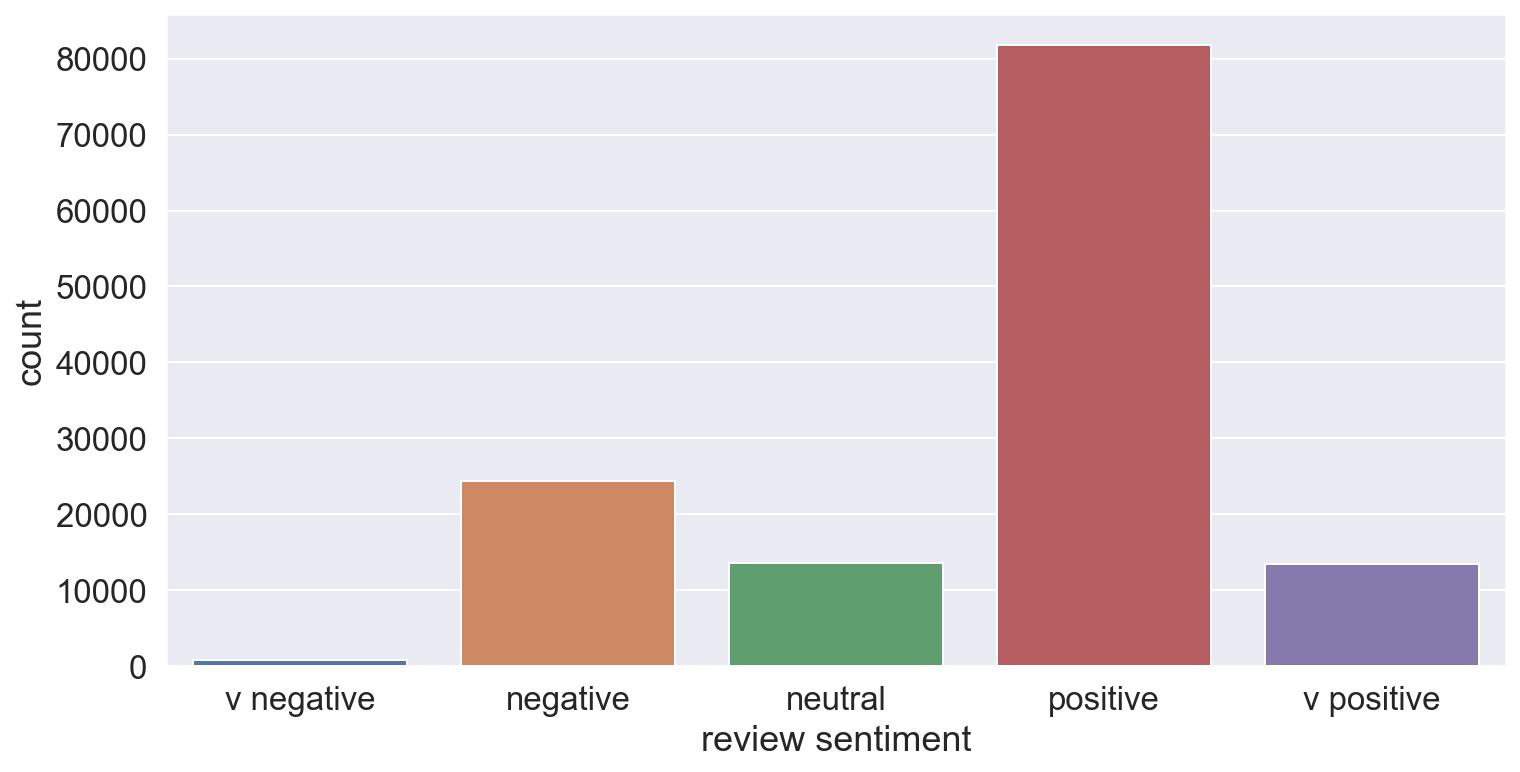

In [ ]:
class_names = ['v negative','negative', 'neutral', 'positive','v positive']

ax = sns.countplot(df.sentiment)
plt.xlabel('review sentiment')
ax.set_xticklabels(class_names);

In [ ]:
df.reset_index(drop=True, inplace=True)

In [ ]:
# Create sentence and label lists
sentences = df.text.values
labels = df.sentiment.values

In [ ]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

In [ ]:
#Tokenize sentences
for sent in sentences:

    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = max_len,           # Pad & truncate all sentences.
                        padding = 'max_length',
                        truncation = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
        
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

Wall time: 1min 16s


In [ ]:
# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

In [ ]:
# Set the batch size.  
batch_size = 32

In [ ]:
# Create the DataLoader.
prediction_data = TensorDataset(input_ids, attention_masks, labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

In [ ]:
# Prediction on test set

print('Predicting labels for {:,} test tweets...'.format(len(input_ids)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

t0 = time.time()

# Predict 
for batch in prediction_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)

    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch

    # Progress update every 200 batches.
    if step % 200 == 0 and not step == 0:
        # Calculate elapsed time in minutes.
        elapsed = format_time(time.time() - t0)

        # Report progress.
        print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

    # Telling the model not to compute or store gradients, saving memory and 
    # speeding up prediction
    with torch.no_grad():
        # Forward pass, calculate logit predictions.
        result = model(b_input_ids, 
                       token_type_ids=None, 
                       attention_mask=b_input_mask,
                       return_dict=True)
    logits = result.logits

    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    # Store predictions and true labels
    predictions.append(logits)
    true_labels.append(label_ids)

print('    DONE.')

Predicting labels for 134,067 test tweets...
    DONE.
Wall time: 15min


In [ ]:
cnt=0
bpred= []
j=len(predictions)

#Create a list of BERT's predicted values for each tweet

#Loop through every batch of predictions
for i in range(j):
    
    #Calculate the prediction for the batch
    pred_labels_i = np.argmax(predictions[i], axis=1).flatten()
    
    #Go through each entry in the batch and add it to the list
    for k in range(len(pred_labels_i)):
        #text=df['text'][cnt]
        #sent=df['sentiment'][cnt]
        #print(f"i:{i}\tk:{cnt}\nText: {text}\nSentiment:{sent}\tPred:{pred_labels_i[k]}")
        bpred.append(pred_labels_i[k])
        cnt += 1
    

#Create a new column with the predicted values for each tweet    
df["b_pred"]=bpred    

In [ ]:
y_true=df.sentiment
y_pred=df.b_pred
target_names= ['v neg', 'neg', 'neu','pos','v pos']

In [ ]:
print(classification_report(y_true, y_pred, target_names=target_names))

              precision    recall  f1-score   support

       v neg       0.14      0.11      0.12       815
         neg       0.34      0.64      0.44     24409
         neu       0.13      0.23      0.17     13593
         pos       0.70      0.49      0.58     81755
       v pos       0.00      0.00      0.00     13495

    accuracy                           0.44    134067
   macro avg       0.26      0.29      0.26    134067
weighted avg       0.50      0.44      0.45    134067



In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(df["b_pred"], df["sentiment"])

0.43694570625135193

In [ ]:
### Ouput

df.to_csv ('for_comp_t.csv', index = False, header=True)